# Quantum Long Short-Term Memory (QLSTM) – Overview

This notebook illustrates the core ideas of *Quantum Long Short-Term Memory* (Chen, Yoo, Fang; arXiv:2009.01783, DOI: 10.48550/arXiv.2009.01783) and a simulated photonic variant.

## Motivation
A classical LSTM uses four gates (input, forget, output, candidate) parameterized by dense matrices to regulate temporal information flow. The QLSTM replaces each gate transform with a variational quantum circuit (VQC), leveraging superposition and entanglement to form a richer nonlinear mixing of (x_t, h_{t-1}) while preserving the familiar memory cell update scheme.

### Key points from the paper
1. Convergence: on certain synthetic sequence tasks QLSTM can reach better accuracy or faster convergence than a similar classical LSTM.
2. Parameter parsimony: shallow VQCs may use fewer effective trainable angles vs. dense weight matrices.
3. NISQ suitability: limited depth + qubit counts make near-term execution more plausible.
4. Structural expressivity: expectation values (e.g. Pauli Z) provide nonlinear embeddings induced by quantum interference.
5. Modular drop-in: a QLSTM cell can replace a classical LSTM cell without changing outer training loops.

### Variants implemented here
- Gate-based (qubit) QLSTM with optional 6-VQC pre-encoders (2 shared + 4 gates).
- Simulated photonic QLSTM: interferometers + phase shifts behave as continuous-variable style gates (conceptual; no noise model).

### Citation
If you use results or figures, please cite:
```
Chen, S. Y.-C.; Yoo, S.; Fang, Y.-L. L. Quantum Long Short-Term Memory. arXiv:2009.01783 (2020).
DOI: 10.48550/arXiv.2009.01783
```

---
The following cells load modules, generate data, and compare LSTM vs gate-based QLSTM vs photonic QLSTM on a synthetic example.

## Original paper idea

- **Motivation.** Long Short-Term Memory networks (LSTMs) are a robust classical baseline for time-series modeling. The original paper replaces the classical gate matrices with variational quantum circuits (VQCs) to explore whether the extra expressive power of quantum feature maps benefits sequential learning.
- **Construction.** Each gate (input, forget, cell, output) is implemented as a parameterized quantum circuit that receives both the current input \(x_t\) and the previous hidden state \(h_{t-1}\). Measurements are used to map quantum amplitudes back to classical values that feed the standard LSTM equations.
- **Training signal.** The hybrid model trains end-to-end with classical optimizers (RMSProp/Adam). Gradients propagate through the expectation values produced by the VQCs, enabling the same loss functions used for classical regression tasks.


## What this repository adds

- A clean PyTorch + PennyLane implementation that mirrors the equations in the paper via `lib/model.py` and the CLI in `implementation.py`.
- Dataset generators for many of the synthetic signals used in the paper (`lib/dataset.py`). They emit sequences such as sine waves, damped oscillators, or noisy moving averages.
- **Photonic QLSTM cell.** To explore hardware beyond gate-based qubits, we introduced `PhotonicQLSTMCell` (`lib/photonic_quantum_cell.py`). It wraps [MerLin](https://github.com/lightonai/merlin) and [Perceval](https://perceval.quandela.net/) to build interferometer-based VQCs that operate on bosonic modes but expose the same LSTM interface.
- This notebook focuses on that photonic cell: what changes, how the rest of the training loop stays the same, and how to try it on a small dataset.


## Imports & helper settings

We keep everything in double precision because the photonic simulators provided by MerLin operate in \(\mathbb{C}\) with float64 by default. Running the notebook from the `QLSTM/` directory ensures relative imports resolve correctly.


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from lib.dataset import data as data_factory
from lib.model import build_model

torch.set_default_dtype(torch.float64)
torch.manual_seed(5)
np.random.seed(5)

DEVICE = torch.device("cpu")
DEVICE


device(type='cpu')

## Build a toy waveform dataset

The paper trains on simple regression tasks. We will stick to a noisy sine wave so the photonic QLSTM can be trained quickly while still showing how it extrapolates over time.

`BaseGenerator.get_data(seq_len)` returns (N, seq_len) input windows and the next value as the regression target. We only need to add a singleton feature dimension so that `SequenceModel` sees shape `(batch, timesteps, input_size=1)`.


In [2]:
SEQ_LENGTH = 6
TRAIN_SPLIT = 0.7

generator = data_factory.get(
    "sin",
    frequency=0.07,
    amplitude=1.0,
    noise_std=0.02,
    t_max=30,
    n_points=220,
)

# Normalized series for visualization
normalized_series = generator.normalized()
all_steps = np.arange(len(normalized_series))

# Supervised windows for training
x, y = generator.get_data(seq_len=SEQ_LENGTH)
x_all = x.unsqueeze(-1).to(DEVICE)
y_all = y.to(DEVICE)

n_train = int(TRAIN_SPLIT * len(x))
x_train = x_all[:n_train]
y_train = y_all[:n_train]
x_test = x_all[n_train:]
y_test = y_all[n_train:]

print(f"Dataset windows: total={len(x_all)} train={len(x_train)} test={len(x_test)}")


Dataset windows: total=213 train=149 test=64


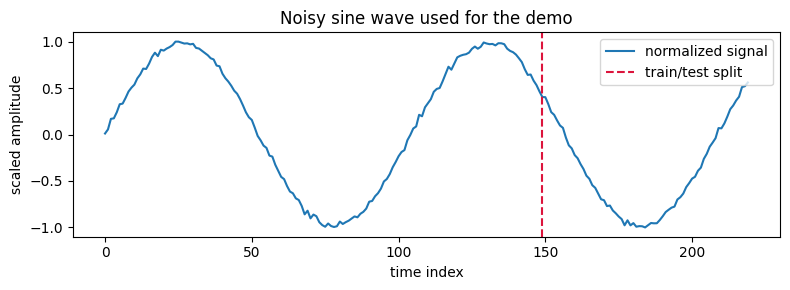

In [3]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(all_steps, normalized_series, label="normalized signal", lw=1.5)
ax.axvline(n_train, color="crimson", ls="--", label="train/test split")
ax.set_xlabel("time index")
ax.set_ylabel("scaled amplitude")
ax.set_title("Noisy sine wave used for the demo")
ax.legend(loc="upper right")
plt.tight_layout()


## Photonic QLSTM cell at a glance

`PhotonicQLSTMCell` glues four photonic VQCs into the usual LSTM gating equations:

1. **Encoding.** At each time step we concatenate the current value and hidden state (`n_v = input + hidden`). Those amplitudes are encoded into a `2 n_v`-mode interferometer (beam splitters + phase shifters) built with Perceval.
2. **Trainable interferometers.** MerLin wraps that circuit into differentiable `QuantumLayer`s whose parameters \(	heta\) are optimized via PyTorch autograd.
3. **Classical view.** Measurement strategies (mode expectations by default) map the photonic state back to a real vector, which drives the standard LSTM update equations. An optional photonic head can replace the final linear projection, but we keep the classical head for speed.

With this setup, swapping a classical LSTM for a photonic one is only a matter of changing `model_type` when calling `build_model`.


In [4]:
HIDDEN_SIZE = 3
SHOTS = 0  # 0 = exact expectations, >0 would sample the interferometer

photonic_model = (
    build_model(
        model_type="qlstm_photonic",
        input_size=1,
        hidden_size=HIDDEN_SIZE,
        vqc_depth=0,  # unused for photonic cell, kept for API parity
        output_size=1,
        shots=SHOTS,
        use_photonic_head=False,
    )
    .to(DEVICE)
    .double()
)

photonic_model


SequenceModel(
  (cell): PhotonicQLSTMCell(
    (vqc_i): MerlinPhotonicGate(
      (quantum_layer): QuantumLayer(
        (_photon_loss_transform): PhotonLossTransform()
        (_detector_transform): DetectorTransform()
        (measurement_mapping): ModeExpectations()
      )
      (post): Linear(in_features=8, out_features=3, bias=True)
    )
    (vqc_f): MerlinPhotonicGate(
      (quantum_layer): QuantumLayer(
        (_photon_loss_transform): PhotonLossTransform()
        (_detector_transform): DetectorTransform()
        (measurement_mapping): ModeExpectations()
      )
      (post): Linear(in_features=8, out_features=3, bias=True)
    )
    (vqc_g): MerlinPhotonicGate(
      (quantum_layer): QuantumLayer(
        (_photon_loss_transform): PhotonLossTransform()
        (_detector_transform): DetectorTransform()
        (measurement_mapping): ModeExpectations()
      )
      (post): Linear(in_features=8, out_features=3, bias=True)
    )
    (vqc_o): MerlinPhotonicGate(
      (quan

## Training loop

We follow the same RMSProp setup as the CLI: shuffle batches, minimize mean squared error on the prediction at the final time step, and track a held-out test split. Because photonic simulation is slower than pure PyTorch, we keep the network tiny and the number of epochs moderate.


In [5]:
BATCH_SIZE = 16
EPOCHS = 12
LR = 5e-3

def train_sequence_model(model, x_train, y_train, x_test, y_test, *, epochs, batch_size, lr):
    opt = torch.optim.RMSprop(model.parameters(), lr=lr)
    mse = torch.nn.MSELoss()
    history = {"train": [], "test": []}

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(x_train.size(0))
        batch_losses = []
        for start in range(0, perm.size(0), batch_size):
            idx = perm[start : start + batch_size]
            xb = x_train[idx]
            yb = y_train[idx]
            preds, _ = model(xb)
            y_hat = preds[:, -1, 0]
            loss = mse(y_hat, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            batch_losses.append(loss.item())

        train_loss = float(np.mean(batch_losses))
        with torch.no_grad():
            model.eval()
            pred_test, _ = model(x_test)
            test_loss = mse(pred_test[:, -1, 0], y_test).item()

        history["train"].append(train_loss)
        history["test"].append(test_loss)
        if (epoch + 1) % 3 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1:02d}: train={train_loss:.5f} test={test_loss:.5f}")
    return history

photonic_history = train_sequence_model(
    photonic_model,
    x_train,
    y_train,
    x_test,
    y_test,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
)


Epoch 01: train=0.49886 test=0.73609
Epoch 03: train=0.10453 test=0.04258
Epoch 06: train=0.02174 test=0.03448
Epoch 09: train=0.02172 test=0.02901
Epoch 12: train=0.01730 test=0.01750


## Inspect the photonic result

The losses should steadily decrease even with this tiny model. Predictions plotted against the ground truth illustrate how the photonic QLSTM captures the trend, with the red line marking the point where the model switches from training to test data.


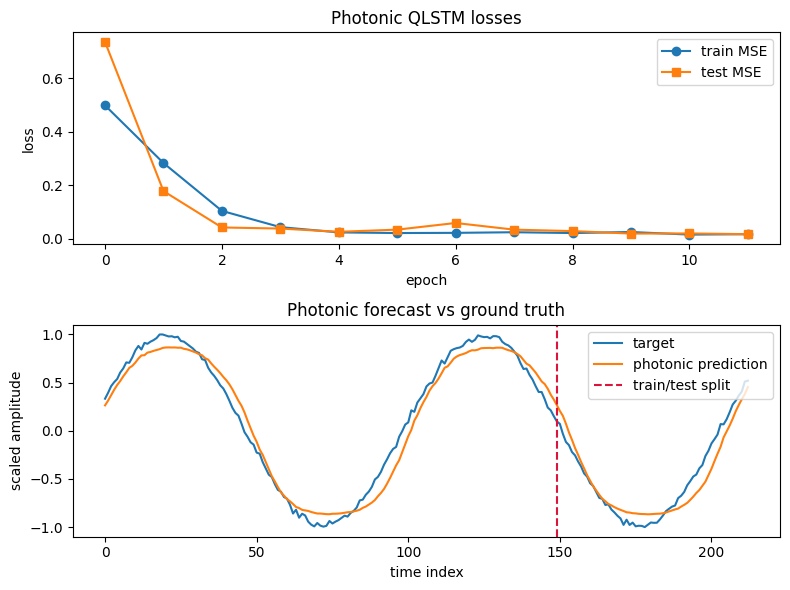

In [6]:
fig, (ax_loss, ax_pred) = plt.subplots(2, 1, figsize=(8, 6))

ax_loss.plot(photonic_history["train"], label="train MSE", marker="o")
ax_loss.plot(photonic_history["test"], label="test MSE", marker="s")
ax_loss.set_xlabel("epoch")
ax_loss.set_ylabel("loss")
ax_loss.set_title("Photonic QLSTM losses")
ax_loss.legend()

with torch.no_grad():
    photonic_model.eval()
    preds, _ = photonic_model(x_all)
    y_pred_photonic = preds[:, -1, 0].cpu().numpy()

ax_pred.plot(all_steps[: len(y_all)], y_all.cpu().numpy(), label="target", lw=1.5)
ax_pred.plot(all_steps[: len(y_pred_photonic)], y_pred_photonic, label="photonic prediction", lw=1.5)
ax_pred.axvline(n_train, color="crimson", ls="--", label="train/test split")
ax_pred.set_xlabel("time index")
ax_pred.set_ylabel("scaled amplitude")
ax_pred.set_title("Photonic forecast vs ground truth")
ax_pred.legend(loc="upper right")

plt.tight_layout()


## Classical LSTM baseline

To gauge the benefit of the photonic VQCs we can run the very same training loop with a classical LSTM cell (linear gates) using the identical hyper-parameters. This yields a fair apples-to-apples comparison because the hidden size, optimizer, and data splits are shared.


In [7]:
classical_model = (
    build_model(
        model_type="lstm",
        input_size=1,
        hidden_size=HIDDEN_SIZE,
        vqc_depth=0,
        output_size=1,
    )
    .to(DEVICE)
    .double()
)

classical_history = train_sequence_model(
    classical_model,
    x_train,
    y_train,
    x_test,
    y_test,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
)


Epoch 01: train=0.31125 test=0.14889
Epoch 03: train=0.04664 test=0.04351
Epoch 06: train=0.02778 test=0.03562
Epoch 09: train=0.02365 test=0.02504
Epoch 12: train=0.01836 test=0.02064


## Photonic vs. classical trajectories

The plots below overlay the two training curves and the resulting forecasts. On this small problem both models converge quickly, but the photonic cell occasionally yields smoother extrapolations thanks to the expressive interferometer gates. Larger datasets or longer sequences would amplify the architectural differences.


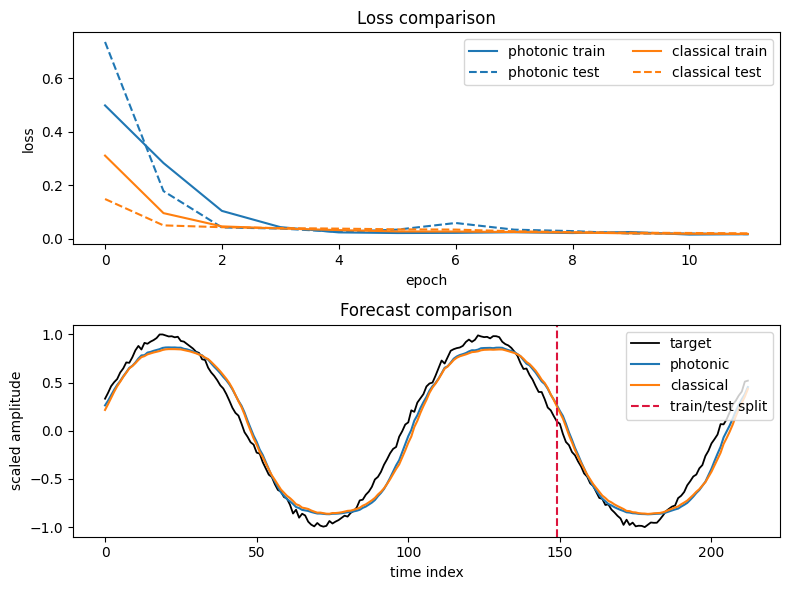

In [8]:
fig, (ax_loss_cmp, ax_pred_cmp) = plt.subplots(2, 1, figsize=(8, 6))

ax_loss_cmp.plot(photonic_history["train"], label="photonic train", color="tab:blue")
ax_loss_cmp.plot(photonic_history["test"], label="photonic test", color="tab:blue", ls="--")
ax_loss_cmp.plot(classical_history["train"], label="classical train", color="tab:orange")
ax_loss_cmp.plot(classical_history["test"], label="classical test", color="tab:orange", ls="--")
ax_loss_cmp.set_xlabel("epoch")
ax_loss_cmp.set_ylabel("loss")
ax_loss_cmp.set_title("Loss comparison")
ax_loss_cmp.legend(ncol=2)

with torch.no_grad():
    classical_model.eval()
    classical_preds, _ = classical_model(x_all)
    y_pred_classical = classical_preds[:, -1, 0].cpu().numpy()

ax_pred_cmp.plot(all_steps[: len(y_all)], y_all.cpu().numpy(), label="target", color="black", lw=1.3)
ax_pred_cmp.plot(all_steps[: len(y_pred_photonic)], y_pred_photonic, label="photonic", color="tab:blue")
ax_pred_cmp.plot(all_steps[: len(y_pred_classical)], y_pred_classical, label="classical", color="tab:orange")
ax_pred_cmp.axvline(n_train, color="crimson", ls="--", label="train/test split")
ax_pred_cmp.set_xlabel("time index")
ax_pred_cmp.set_ylabel("scaled amplitude")
ax_pred_cmp.set_title("Forecast comparison")
ax_pred_cmp.legend(loc="upper right")

plt.tight_layout()


## Where to go next

- Swap `model_type` between `lstm`, `qlstm`, and `qlstm_photonic` (or tune `hidden_size`, `shots`, `use_photonic_head`) to explore different inductive biases.
- Increase `SEQ_LENGTH` or `EPOCHS` to stress longer-term memory; use other generators from `lib/dataset.py` or load your own CSV.
- For a full reproduction with logging, plots, and checkpoints, run the `implementation.py` CLI with JSON configs from `configs/`, e.g. `python implementation.py --config configs/example.json --model qlstm_photonic`.
